<a href="https://colab.research.google.com/github/eshikaalam/XLMRoBERTaBiGRUwithGraph/blob/main/XLMRoBERTaBiGRUwithGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!pip install transformers -q
!pip install datasets -q

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import torch.nn.functional as F
import random
import os
import matplotlib.pyplot as plt


In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: Tesla T4


In [23]:
df = pd.read_csv("/content/drive/MyDrive/dataset/MONOVAB.csv")

# Drop unnecessary columns and rows with missing data
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df.dropna(inplace=True)

# Rename text column
df.rename(columns={"comment": "text"}, inplace=True)

# View class labels
emotion_columns = ['anger', 'contempt', 'disgust', 'enjoyment', 'fear', 'sadness', 'surprise']
df[emotion_columns] = df[emotion_columns].astype(float)


In [24]:
def preprocess(df):
    # Normalize & apply threshold
    threshold = 0.35
    for col in emotion_columns:
        df[col] = df[col] / df[col].max()
        df[col] = df[col].apply(lambda x: 1 if x >= threshold else 0)
    return df

df = preprocess(df)


In [25]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train, y_train = train['text'].tolist(), train[emotion_columns].values.tolist()
X_test, y_test = test['text'].tolist(), test[emotion_columns].values.tolist()


In [26]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


In [27]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }


In [28]:
batch_size = 32

train_dataset = TextDataset(tokenizer, X_train, y_train)
test_dataset = TextDataset(tokenizer, X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [29]:
class XLMRobertaGRUClassifier(nn.Module):
    def __init__(self, num_classes):
        super(XLMRobertaGRUClassifier, self).__init__()
        self.xlmroberta = AutoModel.from_pretrained("xlm-roberta-base")
        self.gru = nn.GRU(input_size=self.xlmroberta.config.hidden_size,
                          hidden_size=self.xlmroberta.config.hidden_size,
                          num_layers=1,
                          batch_first=True,
                          bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(self.xlmroberta.config.hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlmroberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_states = outputs.last_hidden_state
        gru_output, _ = self.gru(hidden_states)
        output = self.linear(self.dropout(gru_output[:, -1, :]))
        return output


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(emotion_columns)
model = XLMRobertaGRUClassifier(num_classes).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [30]:
# Compute class-wise positive weights
label_freq = torch.tensor(np.array(y_train).sum(axis=0)) + 1e-6  # avoid div by 0
pos_weight = (len(y_train) - label_freq) / label_freq

# Loss with pos_weight to handle class imbalance
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))


In [31]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, hamming_loss
import numpy as np
import torch
import torch.nn.functional as F

# Compute metrics
def compute_metrics(y_true, y_pred):
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    subset_accuracy = accuracy_score(y_true, y_pred)  # exact match accuracy
    hamming_acc = 1 - hamming_loss(y_true, y_pred)    # label-wise accuracy
    return micro_f1, macro_f1, micro_precision, macro_precision, subset_accuracy, hamming_acc

# Train for one epoch
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluate on validation set
def eval_epoch(model, loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)

            # Debug: print prediction probability range
            print("Prediction prob range:", probs.min().item(), probs.max().item())

            preds = (probs >= 0.3).float()  # Lower threshold for better signal early on

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = val_loss / len(loader)
    preds = np.vstack(all_preds)
    truths = np.vstack(all_labels)
    return avg_loss, preds, truths

    # Initialize lists to track metrics
train_losses = []
val_losses = []
val_subset_accuracies = []
val_hamming_accuracies = []
train_hamming_accuracies = []
# Training loop with metrics logging
epochs = 5

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss = train_epoch(model, train_loader)

# Evaluate on training set using same eval_epoch function to compute hamming accuracy
    train_eval_loss, train_preds, train_truths = eval_epoch(model, train_loader)
    train_preds = (train_preds >= 0.3).astype(int)
    train_hamming_acc = 1 - hamming_loss(train_truths, train_preds)
    train_hamming_accuracies.append(train_hamming_acc)

    val_loss, preds, truths = eval_epoch(model, test_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    binarized_preds = (np.array(preds) >= 0.3).astype(int)  # Match threshold from eval

    # Compute metrics
    micro_f1, macro_f1, micro_precision, macro_precision, subset_acc, hamming_acc = compute_metrics(truths, binarized_preds)

    # Append metrics for tracking
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_subset_accuracies.append(subset_acc)
    val_hamming_accuracies.append(hamming_acc)

    print(f"Subset Accuracy: {subset_acc:.4f}")
    print(f"Hamming Accuracy: {hamming_acc:.4f}")
    print(f"Micro F1: {micro_f1:.4f} | Macro F1: {macro_f1:.4f}")
    print(f"Micro Precision: {micro_precision:.4f} | Macro Precision: {macro_precision:.4f}")



Epoch 1/5


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0019153030589222908 0.9995112419128418
Prediction prob range: 0.002489703707396984 0.9993783235549927
Prediction prob range: 0.001207847730256617 0.9994426369667053
Prediction prob range: 0.0021245647221803665 0.9994366765022278
Prediction prob range: 0.0025781537406146526 0.9995173215866089
Prediction prob range: 0.0025120298378169537 0.9994480013847351
Prediction prob range: 0.0022095628082752228 0.9994205236434937
Prediction prob range: 0.0027179124299436808 0.9995291233062744
Prediction prob range: 0.001601202180609107 0.9994828701019287
Prediction prob range: 0.001982905901968479 0.999506950378418
Prediction prob range: 0.0017083892598748207 0.9995080232620239
Prediction prob range: 0.001177402213215828 0.9994982481002808
Prediction prob range: 0.002489703707396984 0.9992886781692505
Prediction prob range: 0.0012857798719778657 0.999503493309021
Prediction prob range: 0.0018256918992847204 0.9994900226593018
Prediction prob range: 0.0021642139181494713 0.9

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0025011885445564985 0.9994823932647705
Prediction prob range: 0.0007437641615979373 0.9995658993721008
Prediction prob range: 0.002672765636816621 0.9993984699249268
Prediction prob range: 0.0004951058654114604 0.9991725087165833
Prediction prob range: 0.0015811973717063665 0.9991064667701721
Prediction prob range: 0.0006048399372957647 0.9993591904640198
Prediction prob range: 0.000789628189522773 0.999452531337738
Prediction prob range: 0.0020125180017203093 0.9993383288383484
Prediction prob range: 0.0035075924824923277 0.9993674159049988
Prediction prob range: 0.0010982303647324443 0.9995027780532837
Prediction prob range: 0.002922074170783162 0.9994274377822876
Prediction prob range: 0.0011116210371255875 0.9995067119598389
Prediction prob range: 0.0013021430931985378 0.9994275569915771
Prediction prob range: 0.0022402210161089897 0.9994370341300964
Prediction prob range: 0.0014457370853051543 0.9994001388549805
Prediction prob range: 0.001936948043294251 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0004819039022549987 0.9995517134666443
Prediction prob range: 0.001014548703096807 0.9996920824050903
Prediction prob range: 0.00037098824395798147 0.9995649456977844
Prediction prob range: 0.00161177315749228 0.9995898604393005
Prediction prob range: 0.0009690001606941223 0.9995800852775574
Prediction prob range: 0.0012734411284327507 0.9996055960655212
Prediction prob range: 0.0009258377249352634 0.9995724558830261
Prediction prob range: 0.0004034707963000983 0.9995493292808533
Prediction prob range: 0.0009023791644722223 0.9995680451393127
Prediction prob range: 0.0009759184322319925 0.9996247291564941
Prediction prob range: 0.0006954948185011744 0.9995220899581909
Prediction prob range: 0.0005766919930465519 0.9995642304420471
Prediction prob range: 0.0020996411330997944 0.9995380640029907
Prediction prob range: 0.0003878115094266832 0.9995597004890442
Prediction prob range: 0.0005946119781583548 0.9996322393417358
Prediction prob range: 0.00114491500426083

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0006173356669023633 0.9995834231376648
Prediction prob range: 0.0005942898569628596 0.9996410608291626
Prediction prob range: 0.000558749889023602 0.9995774626731873
Prediction prob range: 0.0006793081993237138 0.9994745850563049
Prediction prob range: 0.0009201693465001881 0.9995526671409607
Prediction prob range: 0.000126286584418267 0.9995237588882446
Prediction prob range: 0.0006069581140764058 0.9995359182357788
Prediction prob range: 0.0008400264196097851 0.9994789958000183
Prediction prob range: 0.0005564682651311159 0.9995678067207336
Prediction prob range: 0.0007278152042999864 0.9996057152748108
Prediction prob range: 0.0008220169111154974 0.9995070695877075
Prediction prob range: 0.00036254216684028506 0.9995602965354919
Prediction prob range: 0.0007697740220464766 0.9995716214179993
Prediction prob range: 0.000365896470611915 0.9995403289794922
Prediction prob range: 0.00040242919931188226 0.9995436072349548
Prediction prob range: 0.0007815176504664

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0002483001444488764 0.9995130300521851
Prediction prob range: 0.00044523514225147665 0.9993817806243896
Prediction prob range: 0.0005981814465485513 0.9995406866073608
Prediction prob range: 0.00012576623703353107 0.9995643496513367
Prediction prob range: 0.0002554451348260045 0.9995966553688049
Prediction prob range: 0.00040722303674556315 0.9994290471076965
Prediction prob range: 0.00014765714877285063 0.9995027780532837
Prediction prob range: 0.0001801342878025025 0.9994990825653076
Prediction prob range: 0.0002752492146100849 0.9994655251502991
Prediction prob range: 0.0006299528176896274 0.9994439482688904
Prediction prob range: 0.00036632700357586145 0.9995530247688293
Prediction prob range: 0.0002824357943609357 0.9995715022087097
Prediction prob range: 0.0005407689604908228 0.9995421171188354
Prediction prob range: 0.00019925607193727046 0.9995217323303223
Prediction prob range: 0.0006143533391878009 0.9995135068893433
Prediction prob range: 0.000588609

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.00021704801474697888 0.9994931221008301
Prediction prob range: 0.0003633172018453479 0.9995599389076233
Prediction prob range: 0.0001315595000050962 0.9995156526565552
Prediction prob range: 0.00023308073286898434 0.9994774460792542
Prediction prob range: 0.00014866444689687341 0.9994962215423584
Prediction prob range: 0.00010986787674482912 0.9994165897369385
Prediction prob range: 9.613284782972187e-05 0.9995864033699036
Prediction prob range: 0.0002330120769329369 0.9993301630020142
Prediction prob range: 0.0004229245241731405 0.9994308352470398
Prediction prob range: 0.00024062083684839308 0.9995608925819397
Prediction prob range: 0.0004052313743159175 0.9994018077850342
Prediction prob range: 0.00033950837678276 0.9994741082191467
Prediction prob range: 0.00022707669995725155 0.9995782971382141
Prediction prob range: 0.0001266781910089776 0.9993894100189209
Prediction prob range: 0.00042124849278479815 0.9994996786117554
Prediction prob range: 0.0002301402

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.00019596559286583215 0.9995483756065369
Prediction prob range: 0.00039045195444487035 0.9995224475860596
Prediction prob range: 0.0002631941461004317 0.9994980096817017
Prediction prob range: 0.0006387496250681579 0.9995710253715515
Prediction prob range: 0.00031240517273545265 0.9989062547683716
Prediction prob range: 0.00021262970403768122 0.9994668364524841
Prediction prob range: 0.00040283496491611004 0.9994727969169617
Prediction prob range: 0.0005447660223580897 0.9994181394577026
Prediction prob range: 0.0002518582623451948 0.9995574355125427
Prediction prob range: 0.0003813711809925735 0.9995414018630981
Prediction prob range: 0.00040147261461243033 0.9995260238647461
Prediction prob range: 0.0004031920398119837 0.9991835951805115
Prediction prob range: 0.0003565642109606415 0.9994914531707764
Prediction prob range: 0.00028978128102608025 0.9995222091674805
Prediction prob range: 0.0006479494622908533 0.9994825124740601
Prediction prob range: 0.00038735

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0003684427938424051 0.9994235038757324
Prediction prob range: 0.0006541053880937397 0.9995261430740356
Prediction prob range: 0.00039952987572178245 0.9994851350784302
Prediction prob range: 0.00032918062061071396 0.9993127584457397
Prediction prob range: 0.0005598221905529499 0.9994463324546814
Prediction prob range: 0.00021781008399557322 0.9993701577186584
Prediction prob range: 0.0001185506844194606 0.9995135068893433
Prediction prob range: 7.052289583953097e-05 0.9991983771324158
Prediction prob range: 0.001789282658137381 0.9994091987609863
Prediction prob range: 0.00020567845785990357 0.9995301961898804
Prediction prob range: 0.0002919832186307758 0.9993442893028259
Prediction prob range: 0.0003793539945036173 0.999446451663971
Prediction prob range: 0.0002550052013248205 0.999544084072113
Prediction prob range: 0.001195602584630251 0.9993808269500732
Prediction prob range: 0.0002301393251400441 0.9994603991508484
Prediction prob range: 0.000838254461996

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.0001909176353365183 0.999482274055481
Prediction prob range: 0.0001236940297530964 0.9994366765022278
Prediction prob range: 0.00012083962064934894 0.999560534954071
Prediction prob range: 0.00017204383038915694 0.9993395209312439
Prediction prob range: 0.00021809228928759694 0.9995394945144653
Prediction prob range: 0.00019238409004174173 0.9994983673095703
Prediction prob range: 0.00020280142780393362 0.9994024038314819
Prediction prob range: 0.00017504517745692283 0.9994858503341675
Prediction prob range: 0.00022960804926697165 0.9995613694190979
Prediction prob range: 0.00021183746866881847 0.9995456337928772
Prediction prob range: 0.000242951005930081 0.9994933605194092
Prediction prob range: 0.00015837835962884128 0.9995623230934143
Prediction prob range: 0.00013073289301246405 0.9993742108345032
Prediction prob range: 0.00015052549133542925 0.9994813799858093
Prediction prob range: 0.00019633272313512862 0.9996122717857361
Prediction prob range: 0.000116

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Prediction prob range: 0.00013621065590996295 0.9993269443511963
Prediction prob range: 0.0002451403415761888 0.9995326995849609
Prediction prob range: 0.0001590691099409014 0.999481737613678
Prediction prob range: 0.00012731031165458262 0.9992751479148865
Prediction prob range: 0.00013802752073388547 0.9994586110115051
Prediction prob range: 0.00013374941772781312 0.9993757605552673
Prediction prob range: 0.0001230737689184025 0.9995571970939636
Prediction prob range: 0.0001964748662430793 0.9991707801818848
Prediction prob range: 0.00019194178457837552 0.9993528723716736
Prediction prob range: 0.00016094371676445007 0.9995797276496887
Prediction prob range: 0.00019071041606366634 0.999388575553894
Prediction prob range: 0.00013464926450978965 0.9994000196456909
Prediction prob range: 0.00017388882406521589 0.9996094107627869
Prediction prob range: 0.00024736658087931573 0.9992462396621704
Prediction prob range: 0.000108763859316241 0.9994827508926392
Prediction prob range: 0.00017716

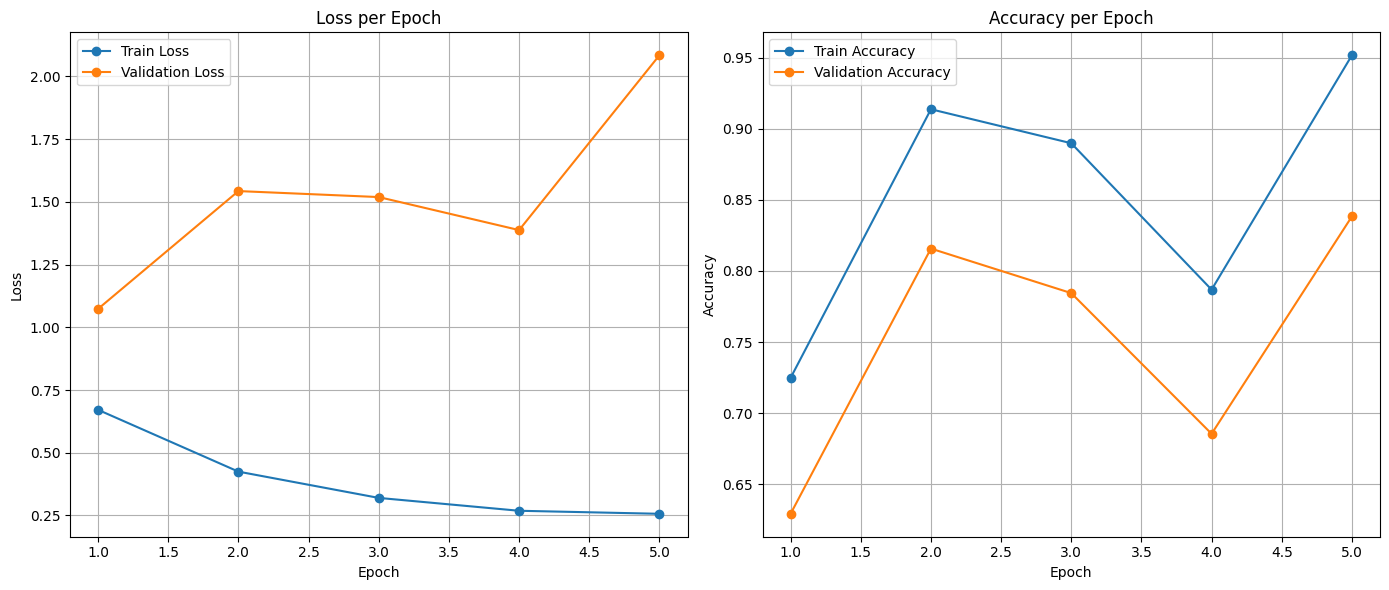

In [33]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 6))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Metrics
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_hamming_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_hamming_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
